In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-07 20:45:56.205226: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-07 20:45:56.205278: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.3)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="gauss", threshold=0.5,
                                  noise_distribution="gauss", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:33280, :], y[:33280]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    """Map optimizer objects to optimizer names, e.g 'sgd', 'rmsprop', etc."""
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

scan_schedule = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 3*28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 3*59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 3*1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 3*1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 3*1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 3*2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 3*1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 3*4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in scan_schedule:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

Epoch 1/119


2022-05-07 20:46:00.169468: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-07 20:46:00.169514: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-07 20:46:00.169538: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-07 20:46:00.169777: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


130/130 [==============================] - 3s 7ms/step - loss: 0.7334 - accuracy: 0.4648 - auc: 0.4515 - val_loss: 0.7084 - val_accuracy: 0.4953 - val_auc: 0.4425
Epoch 2/119
130/130 [==============================] - 1s 6ms/step - loss: 0.7187 - accuracy: 0.4776 - auc: 0.4875 - val_loss: 0.6955 - val_accuracy: 0.5070 - val_auc: 0.5347
Epoch 3/119
130/130 [==============================] - 1s 4ms/step - loss: 0.7081 - accuracy: 0.4887 - auc: 0.5191 - val_loss: 0.6841 - val_accuracy: 0.5220 - val_auc: 0.6217
Epoch 4/119
130/130 [==============================] - 1s 4ms/step - loss: 0.6965 - accuracy: 0.5064 - auc: 0.5544 - val_loss: 0.6732 - val_accuracy: 0.5400 - val_auc: 0.6971
Epoch 5/119
130/130 [==============================] - 1s 4ms/step - loss: 0.6873 - accuracy: 0.5200 - auc: 0.5855 - val_loss: 0.6625 - val_accuracy: 0.5647 - val_auc: 0.7584
Epoch 6/119
130/130 [==============================] - 1s 5ms/step - loss: 0.6762 - accuracy: 0.5446 - auc: 0.6206 - val_loss: 0.6519 - v

Epoch 48/119
130/130 [==============================] - 1s 6ms/step - loss: 0.2611 - accuracy: 0.8892 - auc: 0.9586 - val_loss: 0.1669 - val_accuracy: 0.9361 - val_auc: 0.9869
Epoch 49/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2571 - accuracy: 0.8910 - auc: 0.9597 - val_loss: 0.1644 - val_accuracy: 0.9369 - val_auc: 0.9872
Epoch 50/119
130/130 [==============================] - 1s 5ms/step - loss: 0.2521 - accuracy: 0.8925 - auc: 0.9614 - val_loss: 0.1622 - val_accuracy: 0.9376 - val_auc: 0.9874
Epoch 51/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2477 - accuracy: 0.8942 - auc: 0.9628 - val_loss: 0.1600 - val_accuracy: 0.9381 - val_auc: 0.9876
Epoch 52/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2414 - accuracy: 0.8995 - auc: 0.9645 - val_loss: 0.1578 - val_accuracy: 0.9384 - val_auc: 0.9878
Epoch 53/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2399 - accuracy: 0.8990 - auc: 0.9650 - va

130/130 [==============================] - 1s 5ms/step - loss: 0.1843 - accuracy: 0.9241 - auc: 0.9792 - val_loss: 0.1261 - val_accuracy: 0.9480 - val_auc: 0.9911
Epoch 95/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1830 - accuracy: 0.9252 - auc: 0.9794 - val_loss: 0.1259 - val_accuracy: 0.9481 - val_auc: 0.9911
Epoch 96/119
130/130 [==============================] - 1s 5ms/step - loss: 0.1830 - accuracy: 0.9230 - auc: 0.9795 - val_loss: 0.1257 - val_accuracy: 0.9481 - val_auc: 0.9911
Epoch 97/119
130/130 [==============================] - 1s 5ms/step - loss: 0.1802 - accuracy: 0.9266 - auc: 0.9802 - val_loss: 0.1253 - val_accuracy: 0.9485 - val_auc: 0.9912
Epoch 98/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1811 - accuracy: 0.9244 - auc: 0.9800 - val_loss: 0.1251 - val_accuracy: 0.9481 - val_auc: 0.9912
Epoch 99/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1804 - accuracy: 0.9254 - auc: 0.9801 - val_loss: 0.124

130/130 [==============================] - 1s 4ms/step - loss: 0.2849 - accuracy: 0.8800 - auc: 0.9522 - val_loss: 0.1962 - val_accuracy: 0.9268 - val_auc: 0.9833
Epoch 21/119
130/130 [==============================] - 1s 5ms/step - loss: 0.2767 - accuracy: 0.8820 - auc: 0.9547 - val_loss: 0.1890 - val_accuracy: 0.9287 - val_auc: 0.9842
Epoch 22/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2738 - accuracy: 0.8844 - auc: 0.9552 - val_loss: 0.1830 - val_accuracy: 0.9309 - val_auc: 0.9850
Epoch 23/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2647 - accuracy: 0.8892 - auc: 0.9583 - val_loss: 0.1774 - val_accuracy: 0.9323 - val_auc: 0.9856
Epoch 24/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2624 - accuracy: 0.8877 - auc: 0.9585 - val_loss: 0.1726 - val_accuracy: 0.9334 - val_auc: 0.9862
Epoch 25/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2558 - accuracy: 0.8905 - auc: 0.9606 - val_loss: 0.168

130/130 [==============================] - 1s 4ms/step - loss: 0.1720 - accuracy: 0.9290 - auc: 0.9819 - val_loss: 0.1238 - val_accuracy: 0.9470 - val_auc: 0.9912
Epoch 67/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1710 - accuracy: 0.9303 - auc: 0.9821 - val_loss: 0.1235 - val_accuracy: 0.9475 - val_auc: 0.9913
Epoch 68/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1722 - accuracy: 0.9285 - auc: 0.9819 - val_loss: 0.1233 - val_accuracy: 0.9476 - val_auc: 0.9913
Epoch 69/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1713 - accuracy: 0.9277 - auc: 0.9821 - val_loss: 0.1232 - val_accuracy: 0.9475 - val_auc: 0.9913
Epoch 70/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1709 - accuracy: 0.9285 - auc: 0.9822 - val_loss: 0.1229 - val_accuracy: 0.9477 - val_auc: 0.9913
Epoch 71/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1707 - accuracy: 0.9282 - auc: 0.9822 - val_loss: 0.122

130/130 [==============================] - 0s 4ms/step - loss: 0.1486 - accuracy: 0.9397 - auc: 0.9863 - val_loss: 0.1184 - val_accuracy: 0.9493 - val_auc: 0.9917
Epoch 113/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1480 - accuracy: 0.9383 - auc: 0.9866 - val_loss: 0.1184 - val_accuracy: 0.9491 - val_auc: 0.9917
Epoch 114/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1451 - accuracy: 0.9390 - auc: 0.9872 - val_loss: 0.1183 - val_accuracy: 0.9489 - val_auc: 0.9917
Epoch 115/119
130/130 [==============================] - 0s 3ms/step - loss: 0.1502 - accuracy: 0.9385 - auc: 0.9861 - val_loss: 0.1182 - val_accuracy: 0.9489 - val_auc: 0.9917
Epoch 116/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1465 - accuracy: 0.9397 - auc: 0.9869 - val_loss: 0.1182 - val_accuracy: 0.9490 - val_auc: 0.9918
Epoch 117/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1489 - accuracy: 0.9384 - auc: 0.9864 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.2117 - accuracy: 0.9108 - auc: 0.9727 - val_loss: 0.1371 - val_accuracy: 0.9452 - val_auc: 0.9900
Epoch 39/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2097 - accuracy: 0.9112 - auc: 0.9732 - val_loss: 0.1360 - val_accuracy: 0.9457 - val_auc: 0.9901
Epoch 40/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2092 - accuracy: 0.9121 - auc: 0.9732 - val_loss: 0.1350 - val_accuracy: 0.9459 - val_auc: 0.9902
Epoch 41/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2068 - accuracy: 0.9133 - auc: 0.9738 - val_loss: 0.1341 - val_accuracy: 0.9462 - val_auc: 0.9903
Epoch 42/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2021 - accuracy: 0.9166 - auc: 0.9751 - val_loss: 0.1332 - val_accuracy: 0.9467 - val_auc: 0.9904
Epoch 43/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2022 - accuracy: 0.9155 - auc: 0.9750 - val_loss: 0.132

130/130 [==============================] - 1s 4ms/step - loss: 0.1568 - accuracy: 0.9343 - auc: 0.9850 - val_loss: 0.1203 - val_accuracy: 0.9493 - val_auc: 0.9915
Epoch 85/119
130/130 [==============================] - 0s 4ms/step - loss: 0.1563 - accuracy: 0.9362 - auc: 0.9850 - val_loss: 0.1202 - val_accuracy: 0.9495 - val_auc: 0.9915
Epoch 86/119
130/130 [==============================] - 0s 4ms/step - loss: 0.1534 - accuracy: 0.9372 - auc: 0.9856 - val_loss: 0.1201 - val_accuracy: 0.9495 - val_auc: 0.9916
Epoch 87/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1558 - accuracy: 0.9355 - auc: 0.9851 - val_loss: 0.1200 - val_accuracy: 0.9496 - val_auc: 0.9916
Epoch 88/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1536 - accuracy: 0.9354 - auc: 0.9856 - val_loss: 0.1199 - val_accuracy: 0.9495 - val_auc: 0.9916
Epoch 89/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1552 - accuracy: 0.9363 - auc: 0.9853 - val_loss: 0.119

130/130 [==============================] - 0s 4ms/step - loss: 0.5750 - accuracy: 0.7287 - auc: 0.8038 - val_loss: 0.5273 - val_accuracy: 0.8536 - val_auc: 0.9349
Epoch 11/249
130/130 [==============================] - 0s 4ms/step - loss: 0.5514 - accuracy: 0.7513 - auc: 0.8274 - val_loss: 0.4977 - val_accuracy: 0.8645 - val_auc: 0.9443
Epoch 12/249
130/130 [==============================] - 0s 4ms/step - loss: 0.5287 - accuracy: 0.7643 - auc: 0.8431 - val_loss: 0.4662 - val_accuracy: 0.8729 - val_auc: 0.9519
Epoch 13/249
130/130 [==============================] - 0s 4ms/step - loss: 0.5010 - accuracy: 0.7809 - auc: 0.8629 - val_loss: 0.4336 - val_accuracy: 0.8813 - val_auc: 0.9583
Epoch 14/249
130/130 [==============================] - 0s 4ms/step - loss: 0.4773 - accuracy: 0.7950 - auc: 0.8756 - val_loss: 0.4015 - val_accuracy: 0.8900 - val_auc: 0.9638
Epoch 15/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4517 - accuracy: 0.8094 - auc: 0.8900 - val_loss: 0.370

130/130 [==============================] - 0s 4ms/step - loss: 0.1716 - accuracy: 0.9325 - auc: 0.9819 - val_loss: 0.1225 - val_accuracy: 0.9496 - val_auc: 0.9915
Epoch 57/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1700 - accuracy: 0.9340 - auc: 0.9822 - val_loss: 0.1222 - val_accuracy: 0.9496 - val_auc: 0.9915
Epoch 58/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1701 - accuracy: 0.9324 - auc: 0.9822 - val_loss: 0.1221 - val_accuracy: 0.9496 - val_auc: 0.9915
Epoch 59/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1723 - accuracy: 0.9330 - auc: 0.9816 - val_loss: 0.1220 - val_accuracy: 0.9498 - val_auc: 0.9915
Epoch 60/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1690 - accuracy: 0.9348 - auc: 0.9823 - val_loss: 0.1218 - val_accuracy: 0.9501 - val_auc: 0.9915
Epoch 61/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1665 - accuracy: 0.9343 - auc: 0.9830 - val_loss: 0.121

130/130 [==============================] - 0s 4ms/step - loss: 0.1493 - accuracy: 0.9441 - auc: 0.9860 - val_loss: 0.1201 - val_accuracy: 0.9504 - val_auc: 0.9918
Epoch 103/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1486 - accuracy: 0.9438 - auc: 0.9862 - val_loss: 0.1201 - val_accuracy: 0.9503 - val_auc: 0.9918
Epoch 104/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1494 - accuracy: 0.9419 - auc: 0.9861 - val_loss: 0.1201 - val_accuracy: 0.9506 - val_auc: 0.9918
Epoch 105/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1492 - accuracy: 0.9426 - auc: 0.9861 - val_loss: 0.1201 - val_accuracy: 0.9503 - val_auc: 0.9918
Epoch 106/249
130/130 [==============================] - 1s 4ms/step - loss: 0.1486 - accuracy: 0.9431 - auc: 0.9863 - val_loss: 0.1201 - val_accuracy: 0.9503 - val_auc: 0.9918
Epoch 107/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1486 - accuracy: 0.9421 - auc: 0.9862 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.1407 - accuracy: 0.9457 - auc: 0.9876 - val_loss: 0.1187 - val_accuracy: 0.9506 - val_auc: 0.9919
Epoch 149/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1407 - accuracy: 0.9453 - auc: 0.9877 - val_loss: 0.1186 - val_accuracy: 0.9507 - val_auc: 0.9919
Epoch 150/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1415 - accuracy: 0.9450 - auc: 0.9876 - val_loss: 0.1186 - val_accuracy: 0.9506 - val_auc: 0.9919
Epoch 151/249
130/130 [==============================] - 1s 4ms/step - loss: 0.1407 - accuracy: 0.9449 - auc: 0.9877 - val_loss: 0.1186 - val_accuracy: 0.9505 - val_auc: 0.9919
Epoch 152/249
130/130 [==============================] - 1s 5ms/step - loss: 0.1397 - accuracy: 0.9458 - auc: 0.9879 - val_loss: 0.1185 - val_accuracy: 0.9506 - val_auc: 0.9919
Epoch 153/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1400 - accuracy: 0.9454 - auc: 0.9879 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.1353 - accuracy: 0.9471 - auc: 0.9886 - val_loss: 0.1172 - val_accuracy: 0.9503 - val_auc: 0.9919
Epoch 195/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1362 - accuracy: 0.9460 - auc: 0.9885 - val_loss: 0.1172 - val_accuracy: 0.9503 - val_auc: 0.9919
Epoch 196/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1345 - accuracy: 0.9463 - auc: 0.9889 - val_loss: 0.1171 - val_accuracy: 0.9505 - val_auc: 0.9919
Epoch 197/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1360 - accuracy: 0.9462 - auc: 0.9886 - val_loss: 0.1171 - val_accuracy: 0.9504 - val_auc: 0.9919
Epoch 198/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1344 - accuracy: 0.9463 - auc: 0.9889 - val_loss: 0.1171 - val_accuracy: 0.9504 - val_auc: 0.9919
Epoch 199/249
130/130 [==============================] - 1s 4ms/step - loss: 0.1362 - accuracy: 0.9454 - auc: 0.9885 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.1297 - accuracy: 0.9480 - auc: 0.9896 - val_loss: 0.1162 - val_accuracy: 0.9507 - val_auc: 0.9919
Epoch 241/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1312 - accuracy: 0.9460 - auc: 0.9894 - val_loss: 0.1162 - val_accuracy: 0.9507 - val_auc: 0.9919
Epoch 242/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1325 - accuracy: 0.9453 - auc: 0.9892 - val_loss: 0.1162 - val_accuracy: 0.9506 - val_auc: 0.9919
Epoch 243/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1313 - accuracy: 0.9469 - auc: 0.9894 - val_loss: 0.1162 - val_accuracy: 0.9508 - val_auc: 0.9919
Epoch 244/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1294 - accuracy: 0.9472 - auc: 0.9897 - val_loss: 0.1162 - val_accuracy: 0.9506 - val_auc: 0.9919
Epoch 245/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1325 - accuracy: 0.9465 - auc: 0.9892 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.1908 - accuracy: 0.9251 - auc: 0.9779 - val_loss: 0.1248 - val_accuracy: 0.9495 - val_auc: 0.9913
Epoch 37/249
130/130 [==============================] - 1s 6ms/step - loss: 0.1889 - accuracy: 0.9264 - auc: 0.9781 - val_loss: 0.1240 - val_accuracy: 0.9495 - val_auc: 0.9914
Epoch 38/249
130/130 [==============================] - 1s 6ms/step - loss: 0.1866 - accuracy: 0.9285 - auc: 0.9786 - val_loss: 0.1235 - val_accuracy: 0.9497 - val_auc: 0.9914
Epoch 39/249
130/130 [==============================] - 1s 4ms/step - loss: 0.1862 - accuracy: 0.9277 - auc: 0.9788 - val_loss: 0.1230 - val_accuracy: 0.9493 - val_auc: 0.9914
Epoch 40/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1839 - accuracy: 0.9283 - auc: 0.9791 - val_loss: 0.1226 - val_accuracy: 0.9495 - val_auc: 0.9915
Epoch 41/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1808 - accuracy: 0.9309 - auc: 0.9799 - val_loss: 0.122

130/130 [==============================] - 0s 4ms/step - loss: 0.1489 - accuracy: 0.9422 - auc: 0.9862 - val_loss: 0.1185 - val_accuracy: 0.9502 - val_auc: 0.9919
Epoch 83/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1484 - accuracy: 0.9420 - auc: 0.9863 - val_loss: 0.1185 - val_accuracy: 0.9502 - val_auc: 0.9919
Epoch 84/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1466 - accuracy: 0.9443 - auc: 0.9867 - val_loss: 0.1185 - val_accuracy: 0.9499 - val_auc: 0.9919
Epoch 85/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1500 - accuracy: 0.9419 - auc: 0.9860 - val_loss: 0.1185 - val_accuracy: 0.9498 - val_auc: 0.9919
Epoch 86/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1493 - accuracy: 0.9429 - auc: 0.9861 - val_loss: 0.1185 - val_accuracy: 0.9499 - val_auc: 0.9919
Epoch 87/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1491 - accuracy: 0.9432 - auc: 0.9861 - val_loss: 0.118

130/130 [==============================] - 0s 4ms/step - loss: 0.1389 - accuracy: 0.9460 - auc: 0.9880 - val_loss: 0.1168 - val_accuracy: 0.9505 - val_auc: 0.9919
Epoch 129/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1366 - accuracy: 0.9475 - auc: 0.9884 - val_loss: 0.1168 - val_accuracy: 0.9502 - val_auc: 0.9919
Epoch 130/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1372 - accuracy: 0.9450 - auc: 0.9883 - val_loss: 0.1168 - val_accuracy: 0.9503 - val_auc: 0.9919
Epoch 131/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1370 - accuracy: 0.9466 - auc: 0.9884 - val_loss: 0.1167 - val_accuracy: 0.9502 - val_auc: 0.9919
Epoch 132/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1378 - accuracy: 0.9454 - auc: 0.9882 - val_loss: 0.1167 - val_accuracy: 0.9505 - val_auc: 0.9919
Epoch 133/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1381 - accuracy: 0.9457 - auc: 0.9882 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.1299 - accuracy: 0.9478 - auc: 0.9896 - val_loss: 0.1152 - val_accuracy: 0.9506 - val_auc: 0.9920
Epoch 175/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1319 - accuracy: 0.9481 - auc: 0.9893 - val_loss: 0.1152 - val_accuracy: 0.9503 - val_auc: 0.9920
Epoch 176/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1304 - accuracy: 0.9468 - auc: 0.9895 - val_loss: 0.1152 - val_accuracy: 0.9504 - val_auc: 0.9920
Epoch 177/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1304 - accuracy: 0.9474 - auc: 0.9895 - val_loss: 0.1152 - val_accuracy: 0.9503 - val_auc: 0.9920
Epoch 178/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1310 - accuracy: 0.9480 - auc: 0.9894 - val_loss: 0.1151 - val_accuracy: 0.9504 - val_auc: 0.9920
Epoch 179/249
130/130 [==============================] - 1s 4ms/step - loss: 0.1315 - accuracy: 0.9472 - auc: 0.9894 - val_loss: 

130/130 [==============================] - 0s 3ms/step - loss: 0.1269 - accuracy: 0.9476 - auc: 0.9900 - val_loss: 0.1147 - val_accuracy: 0.9505 - val_auc: 0.9920
Epoch 221/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1273 - accuracy: 0.9468 - auc: 0.9901 - val_loss: 0.1146 - val_accuracy: 0.9505 - val_auc: 0.9920
Epoch 222/249
130/130 [==============================] - 1s 4ms/step - loss: 0.1281 - accuracy: 0.9468 - auc: 0.9899 - val_loss: 0.1146 - val_accuracy: 0.9505 - val_auc: 0.9920
Epoch 223/249
130/130 [==============================] - 1s 4ms/step - loss: 0.1271 - accuracy: 0.9472 - auc: 0.9901 - val_loss: 0.1146 - val_accuracy: 0.9505 - val_auc: 0.9920
Epoch 224/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1272 - accuracy: 0.9470 - auc: 0.9900 - val_loss: 0.1145 - val_accuracy: 0.9502 - val_auc: 0.9920
Epoch 225/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1261 - accuracy: 0.9476 - auc: 0.9901 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.2851 - accuracy: 0.8826 - auc: 0.9524 - val_loss: 0.1828 - val_accuracy: 0.9369 - val_auc: 0.9871
Epoch 17/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2717 - accuracy: 0.8881 - auc: 0.9566 - val_loss: 0.1709 - val_accuracy: 0.9395 - val_auc: 0.9881
Epoch 18/249
130/130 [==============================] - 0s 4ms/step - loss: 0.2614 - accuracy: 0.8913 - auc: 0.9592 - val_loss: 0.1617 - val_accuracy: 0.9417 - val_auc: 0.9889
Epoch 19/249
130/130 [==============================] - 0s 4ms/step - loss: 0.2435 - accuracy: 0.9018 - auc: 0.9648 - val_loss: 0.1539 - val_accuracy: 0.9431 - val_auc: 0.9894
Epoch 20/249
130/130 [==============================] - 0s 4ms/step - loss: 0.2376 - accuracy: 0.9005 - auc: 0.9663 - val_loss: 0.1480 - val_accuracy: 0.9445 - val_auc: 0.9899
Epoch 21/249
130/130 [==============================] - 0s 4ms/step - loss: 0.2302 - accuracy: 0.9073 - auc: 0.9683 - val_loss: 0.143

130/130 [==============================] - 0s 4ms/step - loss: 0.1470 - accuracy: 0.9429 - auc: 0.9866 - val_loss: 0.1200 - val_accuracy: 0.9508 - val_auc: 0.9918
Epoch 63/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1513 - accuracy: 0.9415 - auc: 0.9857 - val_loss: 0.1199 - val_accuracy: 0.9509 - val_auc: 0.9918
Epoch 64/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1509 - accuracy: 0.9417 - auc: 0.9858 - val_loss: 0.1199 - val_accuracy: 0.9510 - val_auc: 0.9918
Epoch 65/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1483 - accuracy: 0.9427 - auc: 0.9862 - val_loss: 0.1199 - val_accuracy: 0.9507 - val_auc: 0.9918
Epoch 66/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1453 - accuracy: 0.9442 - auc: 0.9868 - val_loss: 0.1199 - val_accuracy: 0.9506 - val_auc: 0.9918
Epoch 67/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1480 - accuracy: 0.9428 - auc: 0.9863 - val_loss: 0.119

130/130 [==============================] - 0s 4ms/step - loss: 0.1371 - accuracy: 0.9456 - auc: 0.9884 - val_loss: 0.1179 - val_accuracy: 0.9507 - val_auc: 0.9919
Epoch 109/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1366 - accuracy: 0.9467 - auc: 0.9885 - val_loss: 0.1178 - val_accuracy: 0.9507 - val_auc: 0.9919
Epoch 110/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1360 - accuracy: 0.9469 - auc: 0.9885 - val_loss: 0.1178 - val_accuracy: 0.9506 - val_auc: 0.9919
Epoch 111/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1374 - accuracy: 0.9460 - auc: 0.9883 - val_loss: 0.1178 - val_accuracy: 0.9508 - val_auc: 0.9919
Epoch 112/249
130/130 [==============================] - 1s 4ms/step - loss: 0.1360 - accuracy: 0.9472 - auc: 0.9885 - val_loss: 0.1177 - val_accuracy: 0.9505 - val_auc: 0.9919
Epoch 113/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1358 - accuracy: 0.9471 - auc: 0.9886 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.1314 - accuracy: 0.9479 - auc: 0.9893 - val_loss: 0.1157 - val_accuracy: 0.9501 - val_auc: 0.9920
Epoch 155/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1307 - accuracy: 0.9472 - auc: 0.9895 - val_loss: 0.1157 - val_accuracy: 0.9500 - val_auc: 0.9920
Epoch 156/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1300 - accuracy: 0.9479 - auc: 0.9896 - val_loss: 0.1157 - val_accuracy: 0.9500 - val_auc: 0.9920
Epoch 157/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1300 - accuracy: 0.9474 - auc: 0.9896 - val_loss: 0.1157 - val_accuracy: 0.9501 - val_auc: 0.9920
Epoch 158/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1274 - accuracy: 0.9483 - auc: 0.9900 - val_loss: 0.1157 - val_accuracy: 0.9499 - val_auc: 0.9920
Epoch 159/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1297 - accuracy: 0.9488 - auc: 0.9896 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.1265 - accuracy: 0.9479 - auc: 0.9901 - val_loss: 0.1152 - val_accuracy: 0.9499 - val_auc: 0.9919
Epoch 201/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1257 - accuracy: 0.9475 - auc: 0.9902 - val_loss: 0.1152 - val_accuracy: 0.9498 - val_auc: 0.9919
Epoch 202/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1270 - accuracy: 0.9479 - auc: 0.9901 - val_loss: 0.1152 - val_accuracy: 0.9496 - val_auc: 0.9919
Epoch 203/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1277 - accuracy: 0.9465 - auc: 0.9898 - val_loss: 0.1152 - val_accuracy: 0.9499 - val_auc: 0.9919
Epoch 204/249
130/130 [==============================] - 1s 4ms/step - loss: 0.1273 - accuracy: 0.9467 - auc: 0.9900 - val_loss: 0.1152 - val_accuracy: 0.9496 - val_auc: 0.9919
Epoch 205/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1262 - accuracy: 0.9470 - auc: 0.9901 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.1245 - accuracy: 0.9479 - auc: 0.9904 - val_loss: 0.1153 - val_accuracy: 0.9500 - val_auc: 0.9919
Epoch 247/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1240 - accuracy: 0.9469 - auc: 0.9904 - val_loss: 0.1152 - val_accuracy: 0.9502 - val_auc: 0.9919
Epoch 248/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1246 - accuracy: 0.9483 - auc: 0.9905 - val_loss: 0.1152 - val_accuracy: 0.9501 - val_auc: 0.9919
Epoch 249/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1245 - accuracy: 0.9466 - auc: 0.9904 - val_loss: 0.1153 - val_accuracy: 0.9503 - val_auc: 0.9919
{'learning_rate': 0.006, 'batch': 256, 'epoch': 177, 'optimizer': 'sgd', 'best_loss': {'loss': 0.1151624396443367, 'epoch': 242}, 'best_auc': {'auc': 0.9919851422309875, 'epoch': 164}, 'best_accuracy': {'accuracy': 0.951200008392334, 'epoch': 54}}
Epoch 1/6
4160/4160 [==============================] - 13s

4160/4160 [==============================] - 12s 3ms/step - loss: 0.1694 - accuracy: 0.9406 - auc: 0.9848 - val_loss: 0.1758 - val_accuracy: 0.9463 - val_auc: 0.9852
Epoch 6/6
4160/4160 [==============================] - 15s 4ms/step - loss: 0.1751 - accuracy: 0.9397 - auc: 0.9845 - val_loss: 0.1358 - val_accuracy: 0.9458 - val_auc: 0.9892
{'learning_rate': 0.006, 'batch': 8, 'epoch': 3, 'optimizer': 'rmsprop', 'best_loss': {'loss': 0.13575336337089539, 'epoch': 6}, 'best_auc': {'auc': 0.9892100691795349, 'epoch': 6}, 'best_accuracy': {'accuracy': 0.9474999904632568, 'epoch': 4}}
Epoch 1/6
4160/4160 [==============================] - 18s 4ms/step - loss: 0.1673 - accuracy: 0.9296 - auc: 0.9827 - val_loss: 0.1177 - val_accuracy: 0.9510 - val_auc: 0.9916
Epoch 2/6
4160/4160 [==============================] - 16s 4ms/step - loss: 0.1329 - accuracy: 0.9447 - auc: 0.9890 - val_loss: 0.1213 - val_accuracy: 0.9469 - val_auc: 0.9912
Epoch 3/6
4160/4160 [==============================] - 12s 3m

4160/4160 [==============================] - 14s 3ms/step - loss: 0.1562 - accuracy: 0.9352 - auc: 0.9851 - val_loss: 0.1184 - val_accuracy: 0.9492 - val_auc: 0.9916
{'learning_rate': 0.1, 'batch': 8, 'epoch': 6, 'optimizer': 'adadelta', 'best_loss': {'loss': 0.11840812861919403, 'epoch': 10}, 'best_auc': {'auc': 0.9916316270828247, 'epoch': 10}, 'best_accuracy': {'accuracy': 0.9491999745368958, 'epoch': 10}}
Epoch 1/10
4160/4160 [==============================] - 16s 4ms/step - loss: 0.4929 - accuracy: 0.7536 - auc: 0.8427 - val_loss: 0.2294 - val_accuracy: 0.9129 - val_auc: 0.9767
Epoch 2/10
4160/4160 [==============================] - 14s 3ms/step - loss: 0.2820 - accuracy: 0.8778 - auc: 0.9513 - val_loss: 0.1544 - val_accuracy: 0.9362 - val_auc: 0.9875
Epoch 3/10
4160/4160 [==============================] - 13s 3ms/step - loss: 0.2256 - accuracy: 0.9056 - auc: 0.9690 - val_loss: 0.1348 - val_accuracy: 0.9430 - val_auc: 0.9896
Epoch 4/10
4160/4160 [==============================] - 

4160/4160 [==============================] - 15s 4ms/step - loss: 0.1354 - accuracy: 0.9447 - auc: 0.9887 - val_loss: 0.1229 - val_accuracy: 0.9481 - val_auc: 0.9907
Epoch 12/18
4160/4160 [==============================] - 13s 3ms/step - loss: 0.1370 - accuracy: 0.9433 - auc: 0.9884 - val_loss: 0.1233 - val_accuracy: 0.9485 - val_auc: 0.9912
Epoch 13/18
4160/4160 [==============================] - 15s 4ms/step - loss: 0.1347 - accuracy: 0.9444 - auc: 0.9888 - val_loss: 0.1199 - val_accuracy: 0.9470 - val_auc: 0.9912
Epoch 14/18
4160/4160 [==============================] - 17s 4ms/step - loss: 0.1353 - accuracy: 0.9423 - auc: 0.9887 - val_loss: 0.1213 - val_accuracy: 0.9467 - val_auc: 0.9908
Epoch 15/18
4160/4160 [==============================] - 17s 4ms/step - loss: 0.1361 - accuracy: 0.9446 - auc: 0.9888 - val_loss: 0.1193 - val_accuracy: 0.9481 - val_auc: 0.9912
Epoch 16/18
4160/4160 [==============================] - 18s 4ms/step - loss: 0.1332 - accuracy: 0.9454 - auc: 0.9891 - va

4160/4160 [==============================] - 17s 4ms/step - loss: 0.1411 - accuracy: 0.9411 - auc: 0.9880 - val_loss: 0.1347 - val_accuracy: 0.9493 - val_auc: 0.9907
{'learning_rate': 0.0084, 'batch': 8, 'epoch': 12, 'optimizer': 'nadam', 'best_loss': {'loss': 0.12104841321706772, 'epoch': 2}, 'best_auc': {'auc': 0.9911691546440125, 'epoch': 14}, 'best_accuracy': {'accuracy': 0.9492999911308289, 'epoch': 18}}


In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/243
130/130 [==============================] - 2s 7ms/step - loss: 0.6913 - accuracy: 0.5496 - auc: 0.5690 - val_loss: 0.6596 - val_accuracy: 0.6465 - val_auc: 0.7256
Epoch 2/243
130/130 [==============================] - 0s 3ms/step - loss: 0.6744 - accuracy: 0.5782 - auc: 0.6124 - val_loss: 0.6402 - val_accuracy: 0.7020 - val_auc: 0.8049
Epoch 3/243
130/130 [==============================] - 0s 4ms/step - loss: 0.6548 - accuracy: 0.6149 - auc: 0.6622 - val_loss: 0.6195 - val_accuracy: 0.7501 - val_auc: 0.8508
Epoch 4/243
130/130 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6439 - auc: 0.7006 - val_loss: 0.5972 - val_accuracy: 0.7849 - val_auc: 0.8804
Epoch 5/243
130/130 [==============================] - 0s 4ms/step - loss: 0.6192 - accuracy: 0.6700 - auc: 0.7323 - val_loss: 0.5722 - val_accuracy: 0.8116 - val_auc: 0.9012
Epoch 6/243
130/130 [==============================] - 1s 4ms/step - loss: 0.5983 - accuracy: 0.6954 - auc: 0.7633 - val_loss

130/130 [==============================] - 1s 4ms/step - loss: 0.1748 - accuracy: 0.9302 - auc: 0.9813 - val_loss: 0.1238 - val_accuracy: 0.9493 - val_auc: 0.9912
Epoch 48/243
130/130 [==============================] - 1s 4ms/step - loss: 0.1757 - accuracy: 0.9315 - auc: 0.9809 - val_loss: 0.1235 - val_accuracy: 0.9495 - val_auc: 0.9913
Epoch 49/243
130/130 [==============================] - 1s 4ms/step - loss: 0.1705 - accuracy: 0.9336 - auc: 0.9821 - val_loss: 0.1231 - val_accuracy: 0.9496 - val_auc: 0.9913
Epoch 50/243
130/130 [==============================] - 0s 4ms/step - loss: 0.1707 - accuracy: 0.9335 - auc: 0.9821 - val_loss: 0.1230 - val_accuracy: 0.9496 - val_auc: 0.9913
Epoch 51/243
130/130 [==============================] - 1s 4ms/step - loss: 0.1684 - accuracy: 0.9335 - auc: 0.9825 - val_loss: 0.1227 - val_accuracy: 0.9498 - val_auc: 0.9914
Epoch 52/243
130/130 [==============================] - 1s 4ms/step - loss: 0.1680 - accuracy: 0.9339 - auc: 0.9826 - val_loss: 0.122

130/130 [==============================] - 0s 4ms/step - loss: 0.1458 - accuracy: 0.9437 - auc: 0.9866 - val_loss: 0.1196 - val_accuracy: 0.9503 - val_auc: 0.9918
Epoch 94/243
130/130 [==============================] - 1s 4ms/step - loss: 0.1440 - accuracy: 0.9443 - auc: 0.9871 - val_loss: 0.1196 - val_accuracy: 0.9503 - val_auc: 0.9918
Epoch 95/243
130/130 [==============================] - 1s 5ms/step - loss: 0.1456 - accuracy: 0.9433 - auc: 0.9869 - val_loss: 0.1196 - val_accuracy: 0.9503 - val_auc: 0.9918
Epoch 96/243
130/130 [==============================] - 1s 4ms/step - loss: 0.1439 - accuracy: 0.9436 - auc: 0.9872 - val_loss: 0.1196 - val_accuracy: 0.9506 - val_auc: 0.9918
Epoch 97/243
130/130 [==============================] - 0s 3ms/step - loss: 0.1419 - accuracy: 0.9447 - auc: 0.9875 - val_loss: 0.1196 - val_accuracy: 0.9507 - val_auc: 0.9918
Epoch 98/243
130/130 [==============================] - 0s 3ms/step - loss: 0.1436 - accuracy: 0.9441 - auc: 0.9871 - val_loss: 0.119

130/130 [==============================] - 1s 4ms/step - loss: 0.1381 - accuracy: 0.9456 - auc: 0.9881 - val_loss: 0.1183 - val_accuracy: 0.9502 - val_auc: 0.9918
Epoch 140/243
130/130 [==============================] - 1s 4ms/step - loss: 0.1360 - accuracy: 0.9465 - auc: 0.9886 - val_loss: 0.1183 - val_accuracy: 0.9503 - val_auc: 0.9918
Epoch 141/243
130/130 [==============================] - 1s 4ms/step - loss: 0.1365 - accuracy: 0.9464 - auc: 0.9884 - val_loss: 0.1183 - val_accuracy: 0.9508 - val_auc: 0.9918
Epoch 142/243
130/130 [==============================] - 1s 4ms/step - loss: 0.1365 - accuracy: 0.9455 - auc: 0.9885 - val_loss: 0.1183 - val_accuracy: 0.9507 - val_auc: 0.9918
Epoch 143/243
130/130 [==============================] - 1s 6ms/step - loss: 0.1379 - accuracy: 0.9455 - auc: 0.9882 - val_loss: 0.1183 - val_accuracy: 0.9503 - val_auc: 0.9918
Epoch 144/243
130/130 [==============================] - 0s 4ms/step - loss: 0.1368 - accuracy: 0.9460 - auc: 0.9885 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.1329 - accuracy: 0.9471 - auc: 0.9891 - val_loss: 0.1168 - val_accuracy: 0.9505 - val_auc: 0.9919
Epoch 186/243
130/130 [==============================] - 1s 5ms/step - loss: 0.1320 - accuracy: 0.9480 - auc: 0.9892 - val_loss: 0.1168 - val_accuracy: 0.9503 - val_auc: 0.9919
Epoch 187/243
130/130 [==============================] - 1s 6ms/step - loss: 0.1301 - accuracy: 0.9477 - auc: 0.9895 - val_loss: 0.1168 - val_accuracy: 0.9505 - val_auc: 0.9919
Epoch 188/243
130/130 [==============================] - 1s 6ms/step - loss: 0.1320 - accuracy: 0.9480 - auc: 0.9892 - val_loss: 0.1168 - val_accuracy: 0.9503 - val_auc: 0.9919
Epoch 189/243
130/130 [==============================] - 1s 5ms/step - loss: 0.1324 - accuracy: 0.9478 - auc: 0.9891 - val_loss: 0.1167 - val_accuracy: 0.9503 - val_auc: 0.9919
Epoch 190/243
130/130 [==============================] - 0s 4ms/step - loss: 0.1316 - accuracy: 0.9471 - auc: 0.9894 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.1284 - accuracy: 0.9468 - auc: 0.9898 - val_loss: 0.1158 - val_accuracy: 0.9503 - val_auc: 0.9919
Epoch 232/243
130/130 [==============================] - 1s 4ms/step - loss: 0.1284 - accuracy: 0.9477 - auc: 0.9898 - val_loss: 0.1158 - val_accuracy: 0.9502 - val_auc: 0.9919
Epoch 233/243
130/130 [==============================] - 1s 5ms/step - loss: 0.1274 - accuracy: 0.9481 - auc: 0.9900 - val_loss: 0.1158 - val_accuracy: 0.9502 - val_auc: 0.9919
Epoch 234/243
130/130 [==============================] - 0s 4ms/step - loss: 0.1286 - accuracy: 0.9483 - auc: 0.9898 - val_loss: 0.1158 - val_accuracy: 0.9502 - val_auc: 0.9919
Epoch 235/243
130/130 [==============================] - 0s 4ms/step - loss: 0.1278 - accuracy: 0.9478 - auc: 0.9900 - val_loss: 0.1158 - val_accuracy: 0.9503 - val_auc: 0.9919
Epoch 236/243
130/130 [==============================] - 1s 5ms/step - loss: 0.1278 - accuracy: 0.9469 - auc: 0.9900 - val_loss: 

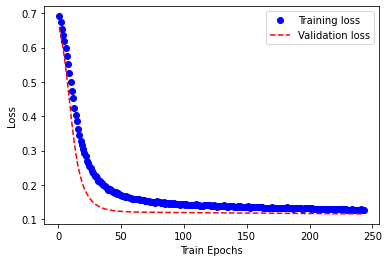

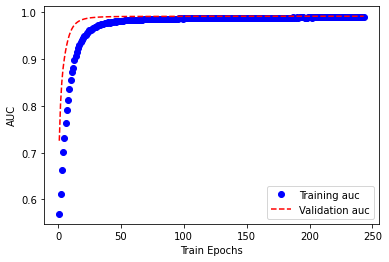

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

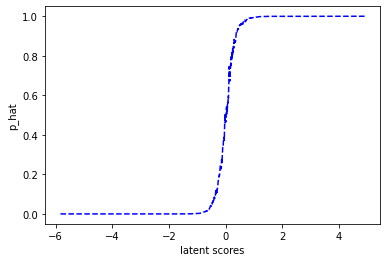

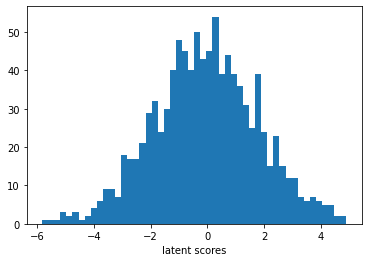

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

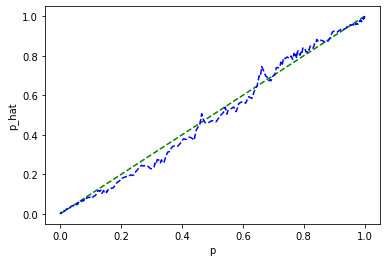

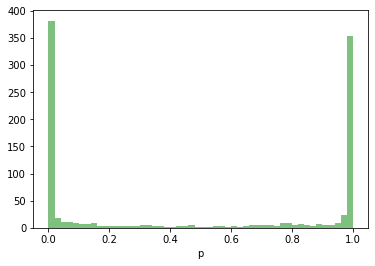

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

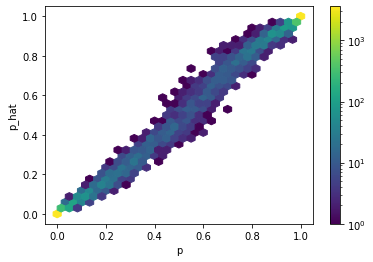

In [10]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

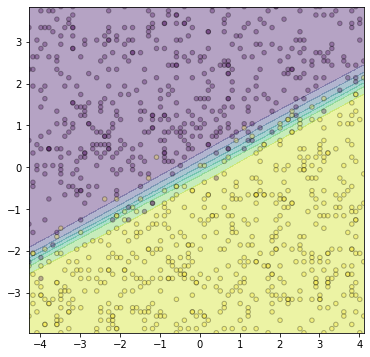

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = np.zeros((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 30)                330       
                                                                 
 dropout_72 (Dropout)        (None, 30)                0         
                                                                 
 dense_97 (Dense)            (None, 30)                930       
                                                                 
 dropout_73 (Dropout)        (None, 30)                0         
                                                                 
 dense_98 (Dense)            (None, 30)                930       
                                                                 
 dropout_74 (Dropout)        (None, 30)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [13]:
champion_params

{'learning_rate': 0.005,
 'batch': 256,
 'epoch': 177,
 'optimizer': 'sgd',
 'best_loss': {'loss': 0.11434397101402283, 'epoch': 243},
 'best_auc': {'auc': 0.992052435874939, 'epoch': 243},
 'best_accuracy': {'accuracy': 0.9508000016212463, 'epoch': 248},
 'model': <keras.engine.sequential.Sequential at 0x7fe22195a1f0>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.1214485689997673, 'epoch': 119},
  'best_auc': {'auc': 0.9915138483047485, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.9492499828338623, 'epoch': 118}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.11806067824363708, 'epoch': 119},
  'best_auc': {'auc': 0.9917700290679932, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.9493499994277954, 'epoch': 112}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.11800511181354523, 'epoch': 119},
  'best_auc': {'auc': 0.9917269349098206, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.949999988079071, 'epoch': 74}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 177,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.1160726547241211, 'epoch': 249},
  'best_auc': {'auc': 0.9919392466545105, 'epoch': 233},
  'be

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25